# Bayesian Neural Networks

We used a BCNN layer implementation from a [github repo](https://github.com/kumar-shridhar/PyTorch-BayesianCNN) by Kumar Shridhar based on a paper....


## Required packages

- `torch`
- `torchvision`
- `seaborn`
- `numby`
- `tensorboard`
- `matplotlib`

## Setup

Below is code that imports the libraries, sets the device, imports the data, and the function for training. 

In [1]:
# Pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as transforms
import torch.utils.tensorboard as tb
import torch.nn.functional as F

# Code from paper
from BCNN.layers.misc import ModuleWrapper
from BCNN.layers.BBB import BBBConv
from BCNN.layers.BBB import BBBLinear

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import tensorboard
import matplotlib.ticker as mticker

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineRenderer.figure_format = 'retina'


# Directory for logging
log_dir = 'logs'


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu") # check if GPU, else use CPU

print(f"Using device: {device}") # Print device

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ConvertImageDtype(),
    # Depending on torchvision version you may need to change these:
    # - If you don't have torchvision.transforms.v2, then import torchvision.transforms
    #   instead and use ToTensor() to replace _both_ of the transforms above.
    # - If you have v2 but it says ToImage() is undefined, then use ToImageTensor() instead.
])

cifar = torchvision.datasets.CIFAR10("cifar", download=True, transform=transform) # Download data
train_size = int((5/6) * len(cifar)) # 5/6 split of data
train_data, valid_data = torch.utils.data.random_split(cifar, [train_size, len(cifar) - train_size]) # Randomly split data

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] # Classes of data, for later

# For data normalization
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)
mean = []
for x, _ in cifar:
    mean.append(torch.mean(x, dim=(1, 2)))
mean = torch.stack(mean, dim=0).mean(dim=0)
std = []
for x, _ in cifar:
    std.append(((x - mean[:,np.newaxis,np.newaxis]) ** 2).mean(dim=(1, 2)))
std = torch.stack(std, dim=0).mean(dim=0).sqrt()

# Data augmentation
normalize = transforms.Normalize(cifar_mean, cifar_std)
augments = transforms.Compose([
            transforms.RandomHorizontalFlip(0.05),
            transforms.RandomGrayscale(0.03),
            transforms.ColorJitter(
                brightness=0.08,
                contrast=0.031,
                saturation=0.031,
                hue=0),
            transforms.Normalize(cifar_mean, cifar_std)
        ])

# Train function
def train(  model_class = None, # Model type
            model_type = "", # String for logging
            lr = 1e-3, # Learning rate
            epochs = 10, # Epochs
            reg = 0, # Regularization
            train_batch_size = 32, # Train batch size
            val_batch_size = 1000): # Validation batch size
 
    # Data loaders
    data_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch_size, shuffle=True) 
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=val_batch_size, shuffle=False)

    # Tracking accuracy over time
    train_accs = []
    valid_accs = []
    
    # Init model to device 
    network = model_class().to(device)
    logger = tb.SummaryWriter(log_dir + '/' + model_type + '-lr-' + str(lr) + '-epochs-' + str(epochs)) # Setup logging
    loss = nn.CrossEntropyLoss() # Loss function

    opt = optim.AdamW(network.parameters(), lr=lr, weight_decay=reg) # Setup optimizer
    scheduler = optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.85) # Setup LR scheduler

    global_step = 0 # Steps for logging
    for i in range(epochs):
        train_acc = []
        network.train()
        # The data loader makes batching easy
        for batch_xs, batch_ys in data_loader:
            batch_xs = batch_xs.to(device)
            preds = network(augments(batch_xs))
            loss_val = loss(preds, batch_ys.to(device))


            # Reset the gradients of all of parameters
            opt.zero_grad()
            # backward() call computes gradients using backpropagation
            loss_val.backward()
            # step() changes the parameters.
            opt.step()
            preds = network(normalize(batch_xs))
            train_acc.append((preds.argmax(dim=1) == batch_ys.to(device)).float().mean())
            # Logging
            logger.add_scalar('loss', loss_val, global_step=global_step)
            logger.add_scalar('training accuracy', (preds.argmax(dim=1) == batch_ys.to(device)).float().mean(), global_step=global_step)
            global_step += 1
            
        train_accs.append(np.mean([tensor.item() for tensor in train_acc]))

        # Mesaure the validation accuracy.
        network.eval()
        val_acc = []
        for batch_xs, batch_ys in valid_loader:
            preds = network(normalize(batch_xs.to(device)))
            val_acc.append((preds.argmax(dim=1) == batch_ys.to(device)).float().mean())
        
        valid_accs.append(np.mean([tensor.item() for tensor in val_acc]))
        logger.add_scalar('validation accuracy', valid_accs[-1], global_step=global_step) # Log validations

        scheduler.step() # Iterate step
        
        print("Epoch:", i + 1, "\nTrain accuracy:", train_accs[-1], "\nValidation accuracy", valid_accs[-1], "\n--------------------------------------------")

    return network, train_accs, valid_accs # Return model

2024-04-05 20:52:13.069800: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-05 20:52:13.075990: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 20:52:13.150831: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 20:52:13.150892: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 20:52:13.150953: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Using device: cpu
Files already downloaded and verified


# Models

Below is the code that defines out CNN and a bayesian CNN model. They are intentionally the similar structure. 

In [2]:
class CNN(nn.Module):
    def __init__(self, arch=None, activation=F.relu):
        super().__init__()
        # Code from pytorch site
        self.activation = activation
        self.conv1 =  nn.Conv2d(3, 6, 5) # Could also add stridding and padding, but not for this dataset
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
class BNN(ModuleWrapper):
  def __init__(self, activation=F.relu):
    super().__init__()
    self.activation = activation
    self.conv1 = BBBConv.BBBConv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = BBBConv.BBBConv2d(6, 16, 5)
    self.fc1 = BBBLinear.BBBLinear(16 * 5 * 5, 120)
    self.fc2 = BBBLinear.BBBLinear(120, 84)
    self.fc3 = BBBLinear.BBBLinear(84, 10)
    self.dropout = nn.Dropout(0.05)


  def forward(self, x):
    x = self.pool(self.activation(self.conv1(x)))
    x = self.pool(self.activation(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = self.dropout(x)
    x = self.activation(self.fc1(x))
    x = self.dropout(x)
    x = self.activation(self.fc2(x))
    x = self.fc3(x)
    return x

# Training

The code chunks below trains the CNN and BCNN model. Both models use the same `train` function which takes the following inputs:

- `model_class`: The type of model to be trained. 
- `model_type`: This is a string that is used for logging purposes. Changing it while only change the tensorboard visualisation. 
- `lr`: Learning rate. A larger number...
- `reg`: Regularization...
- `epochs`: Epochs for training.
- `train_batch_size`: Training batch size. the number is small for accuracy purposes, but large for train time efficency purposes. 
- `val_batch_size`: Validation batch size. It is intentionally larger than the train batch size because 

In [63]:
cnn_model, cnn_train_acc, cnn_val_acc = train( model_class=CNN, 
                    model_type = "CNN", 
                    lr=0.001, 
                    reg=0.001,
                    epochs=100, 
                    train_batch_size=32, 
                    val_batch_size = 5000)

Epoch: 1 
Train accuracy: 0.4275949731389102 
Validation accuracy 0.49320101737976074 
--------------------------------------------
Epoch: 2 
Train accuracy: 0.529691097467383 
Validation accuracy 0.534046471118927 
--------------------------------------------
Epoch: 3 
Train accuracy: 0.5790723330775134 
Validation accuracy 0.54804527759552 
--------------------------------------------
Epoch: 4 
Train accuracy: 0.6052858787413661 
Validation accuracy 0.5776425004005432 
--------------------------------------------
Epoch: 5 
Train accuracy: 0.6310677283192633 
Validation accuracy 0.5880914628505707 
--------------------------------------------
Epoch: 6 
Train accuracy: 0.6472323484267076 
Validation accuracy 0.604689359664917 
--------------------------------------------
Epoch: 7 
Train accuracy: 0.6606389102072141 
Validation accuracy 0.6055394113063812 
--------------------------------------------
Epoch: 8 
Train accuracy: 0.6733979278587874 
Validation accuracy 0.6273877024650574 
-

In [64]:
bnn_model, bnn_train_acc, bnn_val_acc = train( model_class=BNN, 
                    model_type = "BNN", 
                    lr=0.003, 
                    reg=0.001,
                    epochs=100, 
                    train_batch_size=32, 
                    val_batch_size = 5000)

Epoch: 1 
Train accuracy: 0.3144426323867997 
Validation accuracy 0.3921611160039902 
--------------------------------------------
Epoch: 2 
Train accuracy: 0.4126774750575595 
Validation accuracy 0.4333558976650238 
--------------------------------------------
Epoch: 3 
Train accuracy: 0.4473810437452034 
Validation accuracy 0.4479041248559952 
--------------------------------------------
Epoch: 4 
Train accuracy: 0.4753933231005372 
Validation accuracy 0.46450237929821014 
--------------------------------------------
Epoch: 5 
Train accuracy: 0.4974338066001535 
Validation accuracy 0.4749530106782913 
--------------------------------------------
Epoch: 6 
Train accuracy: 0.5172918265541059 
Validation accuracy 0.5066980719566345 
--------------------------------------------
Epoch: 7 
Train accuracy: 0.5380851880276285 
Validation accuracy 0.506847932934761 
--------------------------------------------
Epoch: 8 
Train accuracy: 0.5484458940905602 
Validation accuracy 0.520797461271286

# Save and load models

Uncomment to save or load as necessary.

In [65]:
# torch.save(cnn_model.state_dict(), "Models/cnn_model.pt")
# torch.save(bnn_model.state_dict(), "Models/bnn_model.pt")

In [6]:
cnn_model = CNN()
cnn_model.load_state_dict(torch.load("Models/cnn_model.pt", map_location= device ))
cnn_model = cnn_model.to(device)
bnn_model = BNN()
bnn_model.load_state_dict(torch.load("Models/bnn_model.pt", map_location = device ))
bnn_model = bnn_model.to(device)

# Check and Demo models 

This section visualizes the training of the models in addition to the accuracy of the model. 

In [9]:
# This visualizes the loss of various model during training 

# Reload extension, you may need to run this chunk multiple times

%reload_ext tensorboard 

# Load the tensorboard extension for Jupyter
%load_ext tensorboard
# Start tensorboard and tell it where to look for logs. It will auto-update every second.
%tensorboard --logdir {log_dir} --reload_interval 1 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2024-04-02 21:28:57.203667: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-02 21:28:57.211504: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 21:28:57.341510: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 21:28:57.341641: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 21:28:57.341735: E tensorflow/compiler/xla/stream_executor/cuda

In [7]:
# This section runs predictions on the validation data for 
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=5000, shuffle=False)

#cnn_model.eval() # set model to eval mode
#bnn_model.eval() # set model to eval mode

actual = []
cnn_softmaxes = []
cnn_preds = []
bnn_softmaxes = []
bnn_preds = []

for batch_xs, batch_ys in valid_loader:
    cnn_softmaxes += cnn_model(normalize(batch_xs.to(device))).tolist()
    cnn_preds += cnn_model(normalize(batch_xs.to(device))).argmax(dim=1).tolist()
    actual += batch_ys.tolist()

for batch_xs, _ in valid_loader:
    bnn_softmaxes += bnn_model(normalize(batch_xs.to(device))).tolist()
    bnn_preds += bnn_model(normalize(batch_xs.to(device))).argmax(dim=1).tolist()

In [ ]:
def pretty_graph(train_acc, val_acc, type):
    epochs = len(train_acc)
    train_acc = [tensor.item() for tensor in train_acc]
    val_acc = [tensor.item() for tensor in val_acc]
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.plot(list(range(1, 1 + epochs)), train_acc, label = "Train Accuracy", linestyle = "--")
    plt.plot(list(range(1, 1 + epochs)), val_acc, label = "Validation Accuracy")
    plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.legend()
    plt.title("Validation vs Train accuracy (" + type + ")")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy %")
    ax.xaxis.set_major_locator(plt.MaxNLocator(11))
    #plt.savefig('Images/' + type + '_val_acc_over_time.png', transparent=True) # Save figure for report
    plt.show() 

pretty_graph(cnn_train_acc, cnn_val_acc, "CNN")
pretty_graph(bnn_train_acc, bnn_val_acc, "BNN")

[]

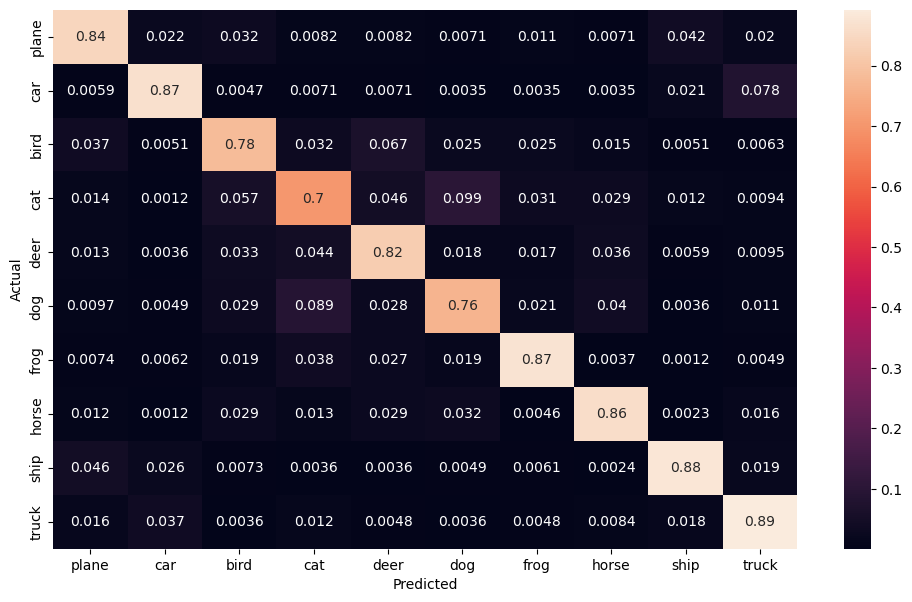

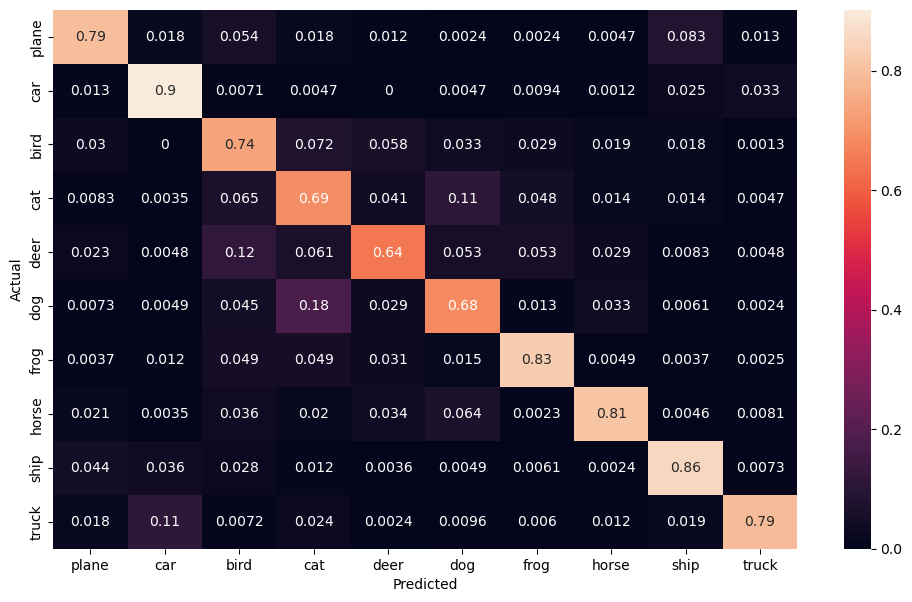

In [8]:
cnn_cf_matrix = confusion_matrix(actual, cnn_preds)
bnn_cf_matrix = confusion_matrix(actual, bnn_preds)

df_cnn_cm = pd.DataFrame(cnn_cf_matrix / np.sum(cnn_cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

df_bnn_cm = pd.DataFrame(bnn_cf_matrix / np.sum(bnn_cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(df_cnn_cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
#plt.savefig('Images/CNN_confusion_matrix.png', transparent=True) # Save figure for report
plt.plot()

plt.figure(figsize = (12,7))
sn.heatmap(df_bnn_cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
#plt.savefig('Images/BNN_confusion_matrix.png', transparent=True) # Save figure for report
plt.plot()

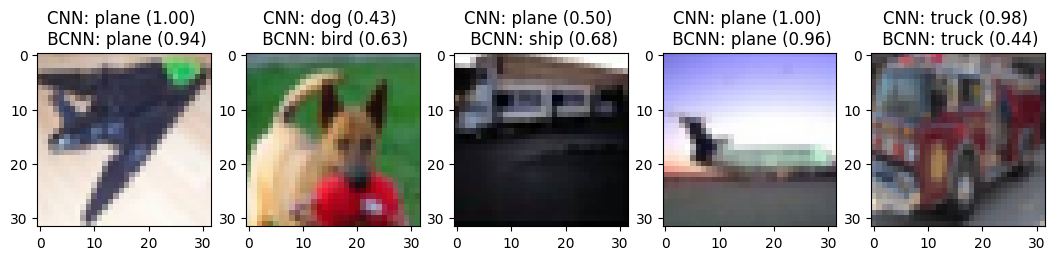

In [115]:
import random 
import math

fig, axs = plt.subplots(1, 5, figsize=(13, 13))
sample = random.sample(range(1, len(valid_data)), 5)

softmax = lambda x : math.e **(x - np.max(x)) / np.sum(math.e**(x - np.max(x))) 

for i in range(5):
    r = sample[i]
    axs[i].imshow(valid_data[r][0].numpy().transpose(1, 2, 0))
    cnn_pred = cnn_preds[r]
    cnn_certainty = softmax(np.array(cnn_softmaxes[r]))
    bnn_pred = bnn_preds[r]
    bnn_certainty = softmax(np.array(bnn_softmaxes[r]))
    axs[i].set_title("CNN: {} ({:.2f}) \n BCNN: {} ({:.2f})".format(classes[cnn_pred], max(cnn_certainty), classes[bnn_pred], max(bnn_certainty)))
plt.show()